In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#for charts


In [2]:
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from sklearn.metrics import confusion_matrix
import itertools

# **1) *Import Images***

In [3]:
#convert 2d image into 4D tensors (Height-Width-Channels-Imagenumbers)
transform1 = transforms.ToTensor()  #makes anything into a tensor

In [4]:
train_data = datasets.MNIST(root='CNN_data', train=True, download=True, transform=transform1)
test_data = datasets.MNIST(root='CNN_data', train=False, download=True, transform=transform1)
### root to save locally in googlecollab , with directory CNN_data
# downloads the data

In [5]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: CNN_data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [6]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: CNN_data
    Split: Test
    StandardTransform
Transform: ToTensor()

# **2) *Convolution, Pooling Layers***

In [7]:
# with images you want a small batch of images
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

In [8]:
#CNN Model      1=image input 6=filters/outputs 3=kernel size 1=stride
conv1= nn.Conv2d(1, 6, 3, 1 ) #out from layer 1 match in from layer 2
conv2= nn.Conv2d(6, 16, 3, 1 )  #play with in and out numbers

In [9]:
for i, (X_Train, y_train) in enumerate(train_data):
  break #grab an image X, with the class y

In [10]:
X_Train

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [11]:
X_Train.shape

torch.Size([1, 28, 28])

In [12]:
x = X_Train.view(1,1,28,28) # 1 batch of 1 image sized 28x28

Convolution

In [13]:
x = F.relu(conv1(x))  #activation function
#performs first convolution from (input) to x after convolution of 1st layer

In [14]:
x.shape #from 28x28 to 26x26 because of filtering
#images get smaller cause there is not much info outside

torch.Size([1, 6, 26, 26])

Pooling

In [15]:
x = F.max_pool2d(x, 2,2) #pooling of kernel 2 and stride 2
x.shape     #from 26x26 to (26/2) 13x13

torch.Size([1, 6, 13, 13])

In [16]:
# Again for 2nd conv and pool
x = F.relu(conv2(x))
x.shape

torch.Size([1, 16, 11, 11])

In [17]:
x = F.max_pool2d(x, 2,2)

In [18]:
x.shape # from 11x11 11/2 =5.5 but we round down to 5x5 cause we can't create data to round up

torch.Size([1, 16, 5, 5])

# **3) *CNN Model***

In [19]:
class ConvolutionalNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1,6,3,1)   #conv layers  followed by a fc nn
    self.conv2 = nn.Conv2d(6,16,3,1)
    self.fc1 = nn.Linear(5*5*16, 120)  #5x5x16 output of cnn with 120 neurons
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)  #10 classes as output from 0-9

  def forward(self, X):   #FORWARD PASS
    X = F.relu(self.conv1(X))
    X = F.max_pool2d(X, 2,2)
    X = F.relu(self.conv2(X))
    X = F.max_pool2d(X ,2,2)
    # Flattens the data
    X = X.view(-1, 16*5*5) #-1 so that we can vary the batch size
    #Fully connected layers
    X = F.relu(self.fc1(X))
    X = F.relu(self.fc2(X))
    X = self.fc3(X)
    return F.log_softmax(X, dim=1)  # 1d output

In [20]:
torch.manual_seed(41)     #Create An Instance Of a model
model = ConvolutionalNetwork()
model   #run the instance

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [21]:
# Loss function Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #smaller lr longer time to train

# **4) *Train & Test***

In [22]:
import time
start_time = time.time()
#When you create this part add some comments to map out the things u will do 123456

#1111Create Variable to track things in EPOCHs
epochs = 5
train_losses = []  # empty list and then we will append things
test_losses = []   # to track things
train_correct = []
test_correct = []

#2222Create for loop for EPOCH
for i in range(epochs):
  trn_corr = 0
  tst_corr = 0


    #3333TRAIN for b(BATCH)
  for b,(X_Train, y_train) in enumerate(train_loader):   # X_train is a 2d image that gets flattend in the model
    b+=1
    y_pred = model(X_Train) #gets predicted value from training set
    loss = criterion(y_pred, y_train) # predictions vs actual # no need to be in loop since we only take the last value

    ###y_pred.data is a tensor of probabilities for each class
    # torch.max finds max value of data along dimension 1 = columns of a tensor.. AND returns max value and indice
    #finds location of max value and gives max value (but max value becomes 1)
    predicted = torch.max(y_pred.data, 1)[1] #predicted class of each item in batch and instead of actual value it gives a value of 1
    batch_corr = (predicted == y_train).sum() #when == True , gives 1. Sum those up for the batch. How many predicted of the batch are equal to actual
    trn_corr += batch_corr #correct predictions of every batch

    #4444 UPDATE PARAMETERS
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    #6666PRINT RESULTS
    if b % 600 == 0: #every 600 batches/6000 item
      print(f'Epoch: {i}  Batch: {b} Loss: {loss.item()}') #.item extracts current value out of a tensor

  train_losses.append(loss) # appends the loss of the last batch ## Better way is to track the average loss
  train_correct.append(trn_corr)

  #5555 TEST after each EPOCH
  test_loss = 0
  with torch.no_grad(): #no gradient since we don't update variables with test date
    for b,(X_Test, y_test) in enumerate(test_loader):
      y_val = model(X_Test) #results from model
      loss = criterion(y_val, y_test)
      test_loss += loss.item()
      predicted = torch.max(y_val.data, 1)[1]
      tst_corr += (predicted == y_test).sum()

  average_test_loss = test_loss / len(test_loader)    # here we take the average of loss in eveery batch
  test_losses.append(average_test_loss)
  test_correct.append(tst_corr)

current_time = time.time()
total = current_time - start_time
print(f'Training Took {total/60} minutes.')

Epoch: 0  Batch: 600 Loss: 0.1623610556125641
Epoch: 0  Batch: 1200 Loss: 0.1502392590045929
Epoch: 0  Batch: 1800 Loss: 0.4744560718536377
Epoch: 0  Batch: 2400 Loss: 0.14238706231117249
Epoch: 0  Batch: 3000 Loss: 0.007758188061416149
Epoch: 0  Batch: 3600 Loss: 0.3836284875869751
Epoch: 0  Batch: 4200 Loss: 0.0038223876617848873
Epoch: 0  Batch: 4800 Loss: 0.0021286322735249996
Epoch: 0  Batch: 5400 Loss: 0.0569545142352581
Epoch: 0  Batch: 6000 Loss: 0.00038789428072050214
Epoch: 1  Batch: 600 Loss: 0.005851339548826218
Epoch: 1  Batch: 1200 Loss: 0.3855525553226471
Epoch: 1  Batch: 1800 Loss: 0.004819948226213455
Epoch: 1  Batch: 2400 Loss: 0.003216963727027178
Epoch: 1  Batch: 3000 Loss: 0.0332382395863533
Epoch: 1  Batch: 3600 Loss: 0.5372857451438904
Epoch: 1  Batch: 4200 Loss: 0.04561494290828705
Epoch: 1  Batch: 4800 Loss: 0.0007510822033509612
Epoch: 1  Batch: 5400 Loss: 0.0001173773780465126
Epoch: 1  Batch: 6000 Loss: 0.14201366901397705
Epoch: 2  Batch: 600 Loss: 0.023733

# **5) *Train & Test***

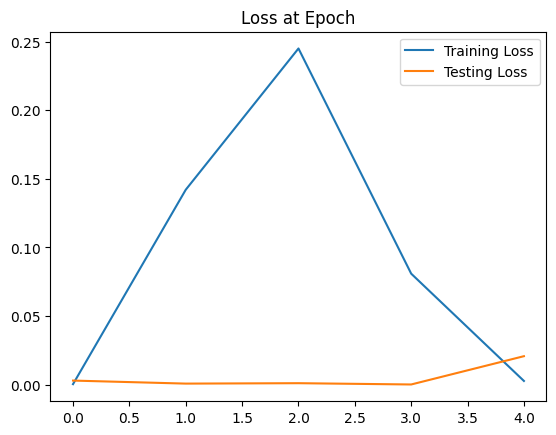

In [23]:
train_losses = [tl.item() for tl in train_losses] # to extract scalar value from tensor
#test_losses is already a float
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Testing Loss')
plt.title('Loss at Epoch')
plt.legend()

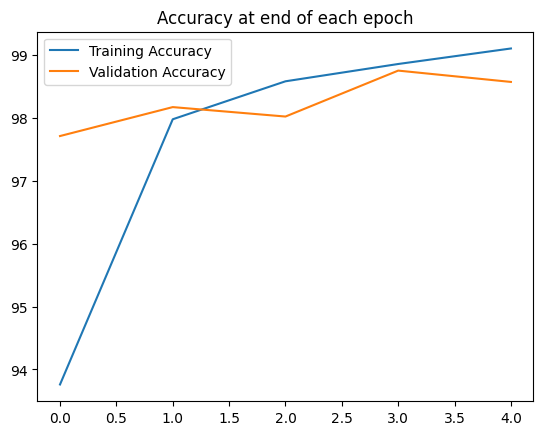

In [24]:
plt.plot([t / 600 for t in train_correct], label='Training Accuracy')
plt.plot([t / 100 for t in test_correct], label='Validation Accuracy')
plt.title('Accuracy at end of each epoch')
plt.legend()

In [25]:
test_load_total = DataLoader(test_data, batch_size=10000, shuffle=False)

In [26]:
with torch.no_grad():
  correct = 0
  for X_test, y_test in test_load_total:
    y_val = model(X_test)
    predicted = torch.max(y_val.data, 1)[1]
    correct += (predicted == y_test).sum()

In [27]:
correct.item() #number of correct from 10.000

9857

# **5) *New Images***

In [28]:
test_data[4143] #Tensor of image , at end it shows the label

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [30]:
test_data[4143][0].reshape(28,28) #only the tensor

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

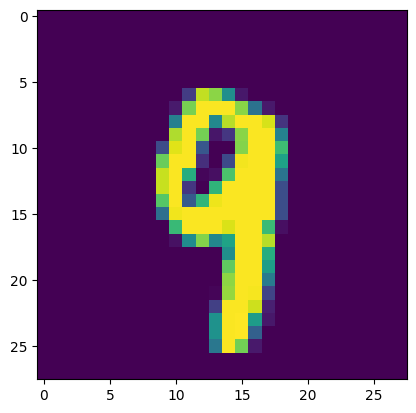

In [32]:
plt.imshow(test_data[4143][0].reshape(28,28))

In [34]:
model.eval() #pass threw model
with torch.no_grad():
  new_prediction = model(test_data[4143][0].view(1,1,28,28)) #batch of 1 for 1 channel 28x28 Im

In [36]:
new_prediction #probabilities of each class

tensor([[-2.1693e+01, -1.8584e+01, -2.1709e+01, -1.5842e+01, -8.6330e+00,
         -1.8415e+01, -3.1769e+01, -1.2734e+01, -1.3396e+01, -1.8273e-04]])

In [37]:
new_prediction.argmax()

tensor(9)